### Import Libraries

In [1]:
import numpy as np
import os
from pathlib import Path
from numpy import asarray
from PIL import Image
import scipy.linalg as la
from  matplotlib import pyplot

### Function to input Data

In [2]:
def load_images_from_folder(folder):
    listc = os.listdir(folder)
    length = len(listc)
    images=np.zeros((100*100,length))
    i=0
    for filename in listc:
        image = Image.open(os.path.join(folder,filename))
        data = asarray(image)
        data = data[:100,:100]
        for k in range(100*100):
            images[k][i]=data[k%100][k//100]
        if (filename[10:13]=='hap'):
            listc[i]=1
        if (filename[10:13]=='sad'):
            listc[i]=0
        i+=1
    return images,listc

### Perform PCA function

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def principal_component(features,k):
    Tran_feature = features.T
    scalar = StandardScaler()
    scalar.fit(Tran_feature)
    scaled_data = scalar.transform(Tran_feature)
    pca = PCA(n_components=k)
    pca.fit(scaled_data)
    Y = (pca.transform(scaled_data)).T
    return Y, pca, scalar

### Softmax Function

In [4]:
def softmax(y):
    y = np.exp(y)
    l = np.zeros(y.shape)
    for i in range(len(y)):
        l[i][0] = y[i]/sum(y)
    return l

### RELU Function

In [5]:
def RELU(y):
    l = np.zeros(y.shape)
    for i in range(len(y)):
        if y[i]<=0:
            l[i]=0
        else:
            l[i]=y[i]
    return l

def derivative_RELU(y):
    l = np.zeros(y.shape)
    for i in range(len(y)):
        if y[i]<=0:
            l[i]=0
        else:
            l[i]=1
    return l

### Learning Function

In [6]:
def DNNlearning(Y, label_train, nodes, learning_rate, max_iter, batch_size, momentum):
    L = 2 # No_of_hidden_layers
    # Parameters
    W1 = np.random.uniform(0, 0.01, (nodes,Y.shape[0]))
    W2 = np.random.uniform(0, 0.01, (nodes,nodes))
    W3 = np.random.uniform(0, 0.01, (2,nodes))
    b1 = np.random.uniform(0, 0.01, (nodes,1))
    b2 = np.random.uniform(0, 0.01, (nodes,1))
    b3 = np.random.uniform(0, 0.01, (2,1))

    # Previous updates for using momentum
    prev_W1 = np.zeros((nodes,n))
    prev_W2 = np.zeros((nodes,nodes))
    prev_W3 = np.zeros((2,nodes))
    prev_b1 = np.zeros((nodes,1))
    prev_b2 = np.zeros((nodes,1))
    prev_b3 = np.zeros((2,1))

    # Gradients
    grad_W1 = np.zeros((nodes,n))
    grad_W2 = np.zeros((nodes,nodes))
    grad_W3 = np.zeros((2,nodes))
    grad_b1 = np.zeros((nodes,1))
    grad_b2 = np.zeros((nodes,1))
    grad_b3 = np.zeros((2,1))

    iter = 0

    #used to take different set of images in a batch
    of = 0 
    # List to save error at each iteration of Grad Descent
    error_list = []
    while(iter<max_iter):
        p=0
        while p < 20:
            k = (p+of)%20                 #to change the set of images in a batch 
    #         print(k)
            if label_train[k] == 0:
                e = np.array([[1],[0]])       #for calculating gradient w.r.t a3 
            else:
                e = np.array([[0],[1]])

            #forward propogation
            a1 = W1@Y[:,k:k+1]+b1
            z1 = RELU(a1)
            a2 = W2@z1+b2
            z2 = RELU(a2)
            a3 = W3@z2+b3
            y_hat = softmax(a3)

            #back propogation
            grad1 = -(e-y_hat)   #grad w.r.t a3 
            grad_W3 += grad1 @ z2.T
            grad_b3 += grad1

            grad2 = W3.T@grad1   #grad wrt z2
            grad3 = np.zeros((len(grad2),1)) #grad wrt a2
            inter = derivative_RELU(a2)
            for i in range(len(grad2)):
                grad3[i] = grad2[i]*inter[i] #grad wrt a2
            grad_W2 += grad3 @ z1.T
            grad_b2 += grad3

            grad4 = W2.T@grad3   #grad wrt z1
            grad5 = np.zeros((len(grad4),1)) #grad wrt a1
            inter = derivative_RELU(a1)
            for i in range(len(grad2)):
                grad5[i] = grad4[i]*inter[i] #grad wrt a1

            grad_W1 += grad5 @ Y[:,k:k+1].T
            grad_b1 += grad5
            #update wieghts
            if p%batch_size == (batch_size-1):
                W1 = W1 - (momentum*prev_W1 + learning_rate*grad_W1/batch_size)
                W2 = W2 - (momentum*prev_W2 + learning_rate*grad_W2/batch_size)
                W3 = W3 - (momentum*prev_W3 + learning_rate*grad_W3/batch_size)
                b1 = b1 - (momentum*prev_b1 + learning_rate*grad_b1/batch_size)
                b2 = b2 - (momentum*prev_b2 + learning_rate*grad_b2/batch_size)
                b3 = b3 - (momentum*prev_b3 + learning_rate*grad_b3/batch_size)

                prev_W1 = (momentum*prev_W1 + learning_rate*grad_W1)
                prev_W2 = (momentum*prev_W2 + learning_rate*grad_W2)
                prev_W3 = (momentum*prev_W3 + learning_rate*grad_W3)
                prev_b1 = (momentum*prev_b1 + learning_rate*grad_b1)
                prev_b2 = (momentum*prev_b2 + learning_rate*grad_b2)
                prev_b3 = (momentum*prev_b3 + learning_rate*grad_b3)

                grad_W1 = np.zeros((nodes,n))
                grad_W2 = np.zeros((nodes,nodes))
                grad_W3 = np.zeros((2,nodes))
                grad_b1 = np.zeros((nodes,1))
                grad_b2 = np.zeros((nodes,1))
                grad_b3 = np.zeros((2,1))
            p+=1

        error = 0
        for l in range(Y.shape[1]):
            a1 = W1@Y[:,l:l+1]+b1
            z1 = RELU(a1)
            a2 = W2@z1+b2
            z2 = RELU(a2)
            a3 = W3@z2+b3
            y_hat = softmax(a3)
            error+= -(np.log(y_hat[label_train[l]]))
        print(error)
        error_list.append(error)
        of+=1
        iter+=1
    
    pyplot.plot(np.linspace(1,20,num=20),error_list)
    pyplot.title("Plot for change in error with iterations")
    pyplot.show()
    return W1, W2, W3, b1, b2, b3
    

### Prediction Function

In [7]:
def prediction(Y_test, W1, W2, W3, b1, b2, b3):
    prediction = []
    for l in range(Y_test.shape[1]):
        a1 = W1@Y_test[:,l:l+1]+b1
        z1 = RELU(a1)
        a2 = W2@z1+b2
        z2 = RELU(a2)
        a3 = W3@z2+b3
        y_hat = softmax(a3)
        if y_hat[0]>y_hat[1]:
            prediction.append(0)
        else:
            prediction.append(1)
    return prediction

### Function to calculate Accuracy

In [8]:
def accuracy(label_test, prediction):
    accuracy = 0
    for i in range(len(label_test)):
        if prediction[i] == label_test[i]:
            accuracy += 1
    accuracy = accuracy * 100 / Y_test.shape[1]
    return accuracy

### Input Train Data

In [9]:
image_path = Path('emotion_classification/train')
images, label_train=load_images_from_folder(image_path.as_posix())

### Input Test Data

In [10]:
test_path = Path('emotion_classification/test')
test, label_test=load_images_from_folder(test_path.as_posix())

### Perform PCA on Train and Test data

In [11]:
n = 12
Y, pca, scalar = principal_component(images,n)
scaled = scalar.transform(test.T)
Y_test = (pca.transform(scaled)).T

### Learning and Prediction using Deep Neural Network model 

### Nodes = 10 W/o momentum

[13.80728434]
[13.78203602]
[13.76664811]
[13.7419828]
[13.6700114]
[13.44991744]
[11.81048302]
[11.99391532]
[11.19093374]
[7.94979388]
[5.79425862]
[5.51901915]
[5.03235774]
[4.06771995]
[3.57600272]
[3.59813456]
[3.74318994]
[3.60129081]
[3.52651419]
[3.47705198]


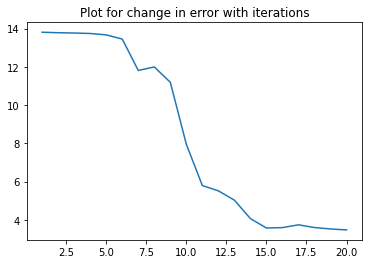

In [12]:
W1, W2, W3, b1, b2, b3 = DNNlearning(Y, label_train,nodes = 10, learning_rate = 0.14, max_iter = 20,
                                     batch_size = 4, momentum = 0)

### Testing

In [13]:
predict = prediction(Y_test,W1, W2, W3, b1, b2, b3)
accur = accuracy(label_test, predict)
print(f'Accuracy on test data is {accur}%')

Accuracy on test data is 80.0%


### Nodes = 15 W/o momentum

[13.80190611]
[13.76801544]
[13.72495739]
[13.5609081]
[12.40580836]
[11.20827111]
[10.24706825]
[6.28228018]
[6.02221376]
[5.08711913]
[4.7860225]
[4.32488624]
[3.99634882]
[3.81951194]
[3.70673445]
[3.62015807]
[3.55107138]
[3.49673776]
[3.45382433]
[3.41911228]


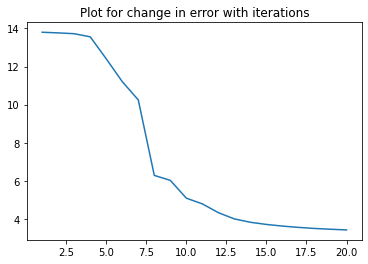

In [20]:
W1, W2, W3, b1, b2, b3 = DNNlearning(Y, label_train,nodes = 15, learning_rate = 0.15, max_iter = 20,
                                     batch_size = 4, momentum = 0)

### Testing

In [21]:
predict = prediction(Y_test,W1, W2, W3, b1, b2, b3)
accur = accuracy(label_test, predict)
print(f'Accuracy on test data is {accur}%')

Accuracy on test data is 80.0%


### Nodes = 10 With momentum

[13.84718913]
[13.79936734]
[13.76527607]
[13.75821432]
[13.75453038]
[13.74815132]
[13.7244445]
[13.67224439]
[13.49692486]
[12.85629693]
[10.9032699]
[9.10266588]
[8.57417992]
[7.37826897]
[9.78370352]
[4.85946317]
[6.1110617]
[4.46081155]
[2.19795064]
[2.30842399]


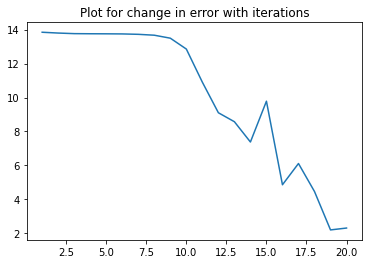

In [16]:
W1, W2, W3, b1, b2, b3 = DNNlearning(Y, label_train,nodes = 10, learning_rate = 0.0054, max_iter = 20,
                                     batch_size = 4, momentum = 0.9)

### Testing

In [17]:
predict = prediction(Y_test,W1, W2, W3, b1, b2, b3)
accur = accuracy(label_test, predict)
print(f'Accuracy on test data is {accur}%')

Accuracy on test data is 100.0%


### Nodes = 15 With momentum

[13.85015354]
[13.78873951]
[13.72862388]
[13.66075674]
[13.4827764]
[12.79412976]
[10.77148071]
[9.21222018]
[8.32984212]
[7.37207944]
[6.21292306]
[5.78585804]
[3.41991856]
[2.34112874]
[1.73346262]
[1.39396497]
[1.16243037]
[1.00678058]
[0.89145592]
[0.81090597]


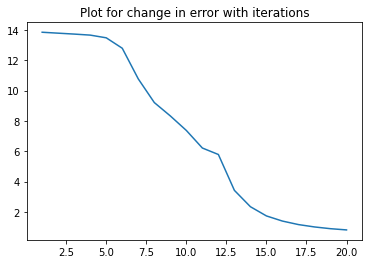

In [22]:
W1, W2, W3, b1, b2, b3 = DNNlearning(Y, label_train,nodes = 15, learning_rate = 0.0055, max_iter = 20,
                                     batch_size = 4, momentum = 0.9)

### Testing

In [23]:
predict = prediction(Y_test,W1, W2, W3, b1, b2, b3)
accur = accuracy(label_test, predict)
print(f'Accuracy on test data is {accur}%')

Accuracy on test data is 100.0%
